Zero-Coupon Yield Curve:
Maturity 0.5 years: 5.9118%
Maturity 1.0 years: 3.4401%
Maturity 1.5 years: 1.0854%
Maturity 2.0 years: 4.4234%


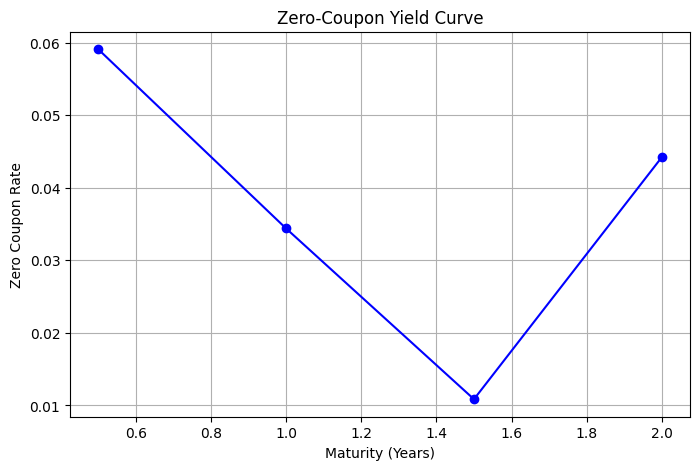

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline

# Classe base per gli strumenti finanziari
class Instrument:
    def __init__(self, maturity, rate):
        self.maturity = maturity
        self.rate = rate  # Tasso osservato sul mercato

# Classe Deposito a breve termine
class Deposit(Instrument):
    def __init__(self, maturity, rate):
        super().__init__(maturity, rate)

# Classe FRA (Forward Rate Agreement)
class FRA(Instrument):
    def __init__(self, start, maturity, fixed_rate):
        super().__init__(maturity, fixed_rate)
        self.start = start  # Quando inizia il contratto

# Classe Swap su tassi d'interesse
class Swap(Instrument):
    def __init__(self, maturity, fixed_rate, float_rate=None):
        super().__init__(maturity, fixed_rate)
        self.float_rate = float_rate  # Per ora non usato, sarà fornito dai dati reali

# Classe Bootstrapping della curva zero-coupon
class Bootstrapping:
    def __init__(self, instruments):
        self.instruments = sorted(instruments, key=lambda x: x.maturity)
        self.zero_rates = {}

    def solve_zero_rate(self, instrument):
        """Calcola il tasso zero-coupon con il metodo iterativo."""
        maturity = instrument.maturity

        # Se è un deposito → formula diretta
        if isinstance(instrument, Deposit):
            return np.log(1 + instrument.rate) / maturity
        
        # Se è un FRA → trova il tasso forward implicito
        elif isinstance(instrument, FRA):
            prev_rate = self.interpolate_rate(instrument.start)
            return ((1 + instrument.rate) / (1 + prev_rate)) ** (1 / (maturity - instrument.start)) - 1
        
        # Se è uno swap → bootstrapping con pagamenti intermedi
        elif isinstance(instrument, Swap):
            def equation(r):
                total_value = 0
                for t in np.arange(1, maturity + 1):
                    discount_factor = np.exp(-self.interpolate_rate(t) * t) if t in self.zero_rates else np.exp(-r * t)
                    total_value += instrument.rate * discount_factor
                total_value += np.exp(-r * maturity)  # Valore nominale alla scadenza
                return total_value - 1  # Deve essere pari al valore teorico del contratto
                
            return fsolve(equation, 0.02)[0]  # Stima iniziale: 2%

    def interpolate_rate(self, t):
        """Interpolazione della curva con spline cubiche."""
        if t in self.zero_rates:
            return self.zero_rates[t]
        maturities = np.array(list(self.zero_rates.keys()))
        rates = np.array(list(self.zero_rates.values()))
        spline = CubicSpline(maturities, rates, bc_type='natural')
        return float(spline(t))

    def build_curve(self):
        """Costruisce la curva zero-coupon con bootstrapping."""
        for inst in self.instruments:
            rate = self.solve_zero_rate(inst)
            self.zero_rates[inst.maturity] = rate
        return self.zero_rates

# Funzione per plottare la curva zero-coupon
def plot_zero_curve(zero_rates):
    maturities = list(zero_rates.keys())
    rates = [zero_rates[m] for m in maturities]
    plt.figure(figsize=(8,5))
    plt.plot(maturities, rates, marker='o', linestyle='-', color='b')
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Zero Coupon Rate")
    plt.title("Zero-Coupon Yield Curve")
    plt.grid(True)
    plt.show()

# Dati sintetici (da sostituire con dati reali in futuro)
instruments = [
    Deposit(0.5, 0.03),  # Deposito a 6 mesi con tasso 3%
    Deposit(1.0, 0.035),  # Deposito a 1 anno con tasso 3.5%
    FRA(1.0, 1.5, 0.04),  # FRA 1.5 anni, tasso fisso 4%
    Swap(2.0, 0.045),  # Interest rate swap a 2 anni con tasso fisso 4.5%
]

# Costruzione della curva
bootstrap = Bootstrapping(instruments)
zero_curve = bootstrap.build_curve()

# Stampa e plot
print("Zero-Coupon Yield Curve:")
for m, r in zero_curve.items():
    print(f"Maturity {m} years: {r:.4%}")

plot_zero_curve(zero_curve)